使用参数加权（离群点为权重为2）进行训练

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# Load the data
data = pd.read_csv('merged.csv')  # Replace with the path to your CSV file

# Extracting the relevant columns
X = data[['net_i', 'net_j', 'net_secs'
# ,'scenarioLinkKMRail','scenarioLinkSavedSecsRail','LBarRail','nMinusRail','savedSecsRail'
]]
y = data['deltaLkRoad']

# Identifying high cost-effectiveness points (outliers)
# We will use a quantile-based approach to define high cost-effectiveness points
threshold_y = np.percentile(y, 75)  # 75th percentile of CkDiffRoad
threshold_x = np.percentile(X['net_secs'], 25)  # 25th percentile of net_secs
weights = np.where((y > threshold_y) & (X['net_secs'] < threshold_x), 2, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=63)

# Parameter tuning with GridSearchCV for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train, sample_weight=weights[X_train.index])

# Best parameters from grid search
best_params = grid_search.best_params_

# Create and train the RandomForestRegressor model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train, sample_weight=weights[X_train.index])

# Predict on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
r2_score_optimized = r2_score(y_test, y_pred)

print(f"Optimized R² score: {r2_score_optimized}")


Optimized R² score: 0.7194665903205859


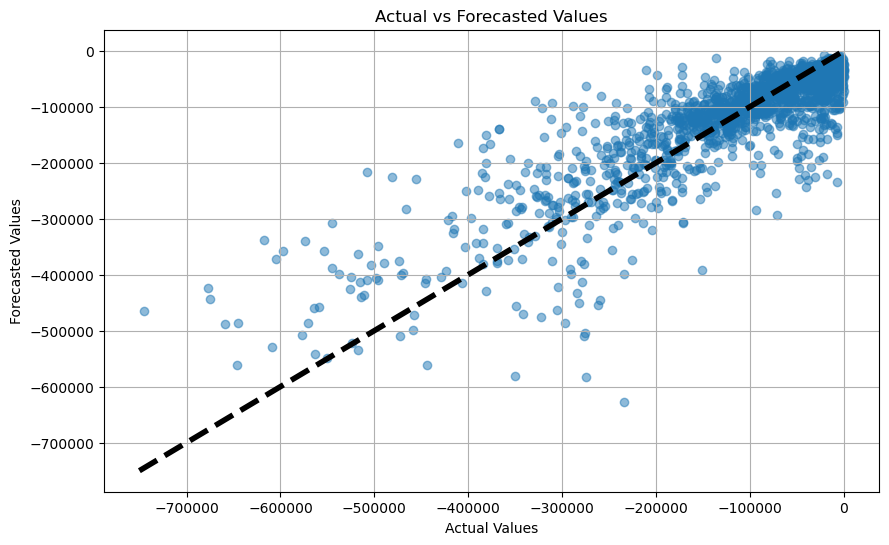

In [2]:
import matplotlib.pyplot as plt

# After model prediction
y_pred = best_rf_model.predict(X_test)

# Plotting the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Plot a diagonal line for reference
plt.title('Actual vs Forecasted Values')
plt.xlabel('Actual Values')
plt.ylabel('Forecasted Values')
plt.grid(True)
plt.show()

仅使用离群点为训练数据

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# Load the data
data = pd.read_csv('merged.csv')  # Replace with the path to your CSV file

# Extracting the relevant columns
X = data[['net_i', 'net_j', 'net_secs']]
y = data['CkDiffRoad']

# Identifying high cost-effectiveness points (outliers)
# We will use a quantile-based approach to define high cost-effectiveness points
threshold_y = np.percentile(y, 75)  # 75th percentile of CkDiffRoad
threshold_x = np.percentile(X['net_secs'], 25)  # 25th percentile of net_secs
outliers = (y > threshold_y) & (X['net_secs'] < threshold_x)

# Use only the outliers as the training data
X_outliers = X[outliers]
y_outliers = y[outliers]

# Split the outliers data into training and testing sets
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(
    X_outliers, y_outliers, test_size=0.2, random_state=42
)

# Create and train the RandomForestRegressor model
rf_outliers = RandomForestRegressor(random_state=42)
rf_outliers.fit(X_train_outliers, y_train_outliers)

# Predict on the test set
y_pred_outliers = rf_outliers.predict(X_test_outliers)

# Evaluate the model
r2_score_outliers_only = r2_score(y_test_outliers, y_pred_outliers)

print(f"R² score using only outliers: {r2_score_outliers_only}")


R² score using only outliers: 0.5560917418934315


In [ ]:
使用复杂加权

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged.csv')  # Replace with the path to your CSV file

# Extracting the relevant columns
X = data[['net_i', 'net_j', 'net_secs']]
y = data['CkDiffRoad']

# Identifying high cost-effectiveness points (outliers) using Isolation Forest
iso_forest = IsolationForest(contamination=0.1)  # Adjust contamination as needed
outliers_iso = iso_forest.fit_predict(X) == -1

# Calculate distance-based weights
weights = np.linalg.norm(X - X[outliers_iso].mean(), axis=1)
weights = 1 / (weights + 0.1)  # To avoid division by zero, add a small constant

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter tuning with GridSearchCV for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=84)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train, sample_weight=weights[X_train.index])

# Best parameters from grid search
best_params = grid_search.best_params_

# Create and train the RandomForestRegressor model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=84)
best_rf_model.fit(X_train, y_train, sample_weight=weights[X_train.index])

# Predict on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
r2_score_optimized = r2_score(y_test, y_pred)

print(f"Optimized R² score: {r2_score_optimized}")

d:\Software\anaconda\envs\geospatial\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Optimized R² score: 0.7764713636655693
